<center><h1>Making a LIF neuron in python using caspian</h1></center>

**Neuro**: provides utilities for data encoding (e.g., converting continuous input values like Iris features into spike trains). It does not simulate neurons itself — instead, it prepares input spikes.

**Caspian**: is the SNN simulator. It defines neurons (e.g., LIF), synapses, delays, weights, and runs the actual spiking dynamics.

**EONS**: evolutionary optimizer — it evolves networks in Caspian to solve tasks.

So in short:
<ul>
<li>Neuro → encodes input data into spike trains</li>
<li>Caspian → simulates neurons</li>
<li>EONS → optimizes networks</li>
</ul>

<h2>Theory of LIF Neurons</h2>

The Leaky Integrate-and-Fire (LIF) model describes how a neuron’s membrane potential evolves under input currents.
Differential Equation

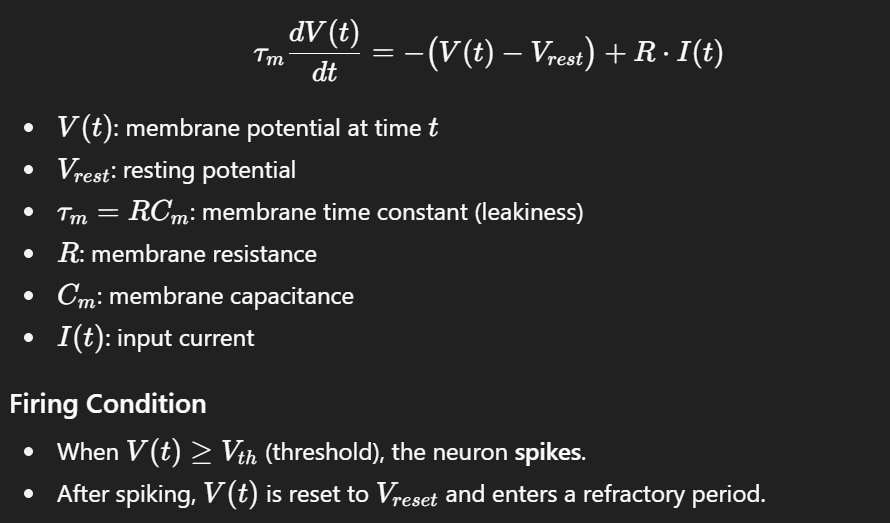



<h2>Defining Parameters</h2>
In Caspian, LIF neurons and synapses have tunable parameters. Important ones include:

<ul>
<li>sim_time → how long to run the network (ms or timesteps).</li>
<li>n_spikes → max number of spikes per input neuron during encoding.</li>
<li>interval → spacing between spikes in encoding.</li>
<li>Weight → synaptic strength.</li>
<li>Delay → synaptic transmission delay.</li>
<li>Threshold → neuron firing threshold.</li>
<li>Refractory period → time after a spike before firing again.</li>
</ul>

In [19]:
#!/usr/bin/env python3
# LIF demo: encoder → caspian processor → decoder (no templates/utilities)

import json
import numpy as np
import caspian
import neuro

# ============================================================
# 1) Load Caspian processor parameters from config/caspian.json
# ============================================================
with open("config/caspian.json") as f:
    caspian_params = json.load(f)
npu = caspian.Processor(caspian_params)

# ============================================================
# 2) Build a tiny LIF network AS JSON with explicit properties
#    Schema:
#      Properties.node_properties  = ["Threshold"]
#      Properties.edge_properties  = ["Weight","Delay"]
#      Each node -> {"id": <int>, "values": [<Threshold>]}
#      Each edge -> {"n1": pre, "n2": post, "values": [<Weight>, <Delay>]}
# ============================================================
n_inputs  = 3
n_outputs = 2

node_props = ["Threshold"]
edge_props = ["Weight", "Delay"]

nodes = []
for i in range(n_inputs):              # inputs
    nodes.append({"id": i, "values": [10]})
for j in range(n_outputs):             # outputs
    nid = n_inputs + j
    nodes.append({"id": nid, "values": [10]})

edges = []
for i in range(n_inputs):
    for j in range(n_outputs):
        pre  = i
        post = n_inputs + j
        edges.append({"n1": pre, "n2": post, "values": [16.0, 1]})  # Weight=16, Delay=1

net_json = {
    "Nodes": nodes,
    "Edges": edges,
    "Inputs": list(range(n_inputs)),
    "Outputs": list(range(n_inputs, n_inputs + n_outputs)),
    "Network_Values": [],
    "Associated_Data": {},
    "Properties": {
        "node_properties":   node_props,
        "edge_properties":   edge_props,
        "network_properties": []
    }
}

# IMPORTANT: from_json needs a JSON STRING, not a dict
net = neuro.Network()
net.from_json(json.dumps(net_json))
npu.load_network(net)

# ============================================================
# 3) Encoder (value → spikes over a window of ticks)
# ============================================================
tpc = 15  # ticks per inference window

encoder_params = {
    "dmin": [0.0] * n_inputs,
    "dmax": [1.0] * n_inputs,
    "interval": tpc,
    "named_encoders": {"s": "spikes"},
    "use_encoders": ["s"] * n_inputs
}
encoder = neuro.EncoderArray(encoder_params)

# ============================================================
# 4) Decoder (spikes → rates)
# ============================================================
decoder_params = {
    "dmin": [0.0] * n_outputs,
    "dmax": [1.0] * n_outputs,
    "divisor": tpc,  # rate = count / tpc
    "named_decoders": {"r": {"rate": {"discrete": False}}},
    "use_decoders": ["r"] * n_outputs
}
decoder = neuro.DecoderArray(decoder_params)

# ============================================================
# 5) Forward pass: encode → simulate → decode
# ============================================================
def forward(x_vec):
    """
    x_vec: length n_inputs, values within [dmin[i], dmax[i]].
    Returns:
        rates: length-n_outputs decoded rates
        pred:  argmax index over rates
    """
    spikes = encoder.get_spikes(x_vec)
    npu.clear_activity()
    npu.apply_spikes(spikes)

    npu.run(2)     # optional settle
    npu.run(tpc)   # run for one encoder window

    rates = decoder.get_data_from_processor(npu)
    pred  = int(np.argmax(rates))
    return rates, pred

# ---------------------------
# Example input in [0,1]^3
# ---------------------------
if __name__ == "__main__":
    x = np.array([0.2, 0.8, 0.5], dtype=float)
    rates, pred = forward(x)
    print("Output rates:", rates)
    print("Predicted class (argmax rate):", pred)


RuntimeError: JSON is not an object.
